<a href="https://colab.research.google.com/github/gibranfp/CursoDatosMasivosI/blob/main/2c_k_means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. *K-medias con PySpark*


                                                              
En este notebook haremos una revisión de como usar la técnica de K-medias para tareas de agrupamiento (*clustering*).


## 3.1 Introducción


Supongamos que tenemos una coleccion de puntos $\{\mathbf{x}_i \}_{i = 1}^n$ que viven en un espacio $N$-dimensional. Dichos puntos no están asociados a ningun tipo de clase o algo parecido. Sin embargo, nosotros podríamos estar interesados en encontrar elementos *similares* entre si. Los algoritmos de agrupamiento responden a esta necesidad, permitiéndonos crear grupos de objetos, de tal forma que los objetos dentro de un mismo grupo presentan cierto grado de *similaridad*.


K-medias (*K-means* en ingles) es una tecnica de agrupamiento, de las muchas que existen. Conceptualmente hablando, un paso difícil de difinir es como medir las similaridad entre objetos. En el caso particular de nuestro conjunto de puntos, la idea de que los puntos *similares* son los que están cerca entre si aparece de forma natural. K-medias hace uso justo esta idea, definiendo como medida de *similaridad* la distancia euclidiana


$$
d = ||\mathbf{x} - \mathbf{y}||_2 = \sqrt{\sum_i (x_i-y_i)^2} = \sqrt{(\mathbf{x} - \mathbf{y})^T (\mathbf{x} - \mathbf{y})}
$$


La idea general detrás K-medias es la de encontrar $K$ puntos $\{\mu_i\}_{i=1}^K$ que sirvan para representar grupos de elementos, de forma especifica son los promedios (por eso la palabra medias) de todos los puntos que encuentran en un mismo grupo. Cada punto puede ser asignado unicamente a un grupo, se le asigna al grupo representado por el $\mu_i$ más cercano.


De forma algorítmica, y muy a grosso modo, la técnica de K-medias puede describirse de la siguiente manera


1.   Inicializar K puntos $\mathbf{\mu}_1, \mathbf{\mu}_2, ...,\mathbf{\mu}_K$ de forma aleatoria.
2.   Encontrar el $\mathbf{\mu}_i$ que es mas cercano a cada $\mathbf{x}_i$, lo cual asignara automaticamente a cada $\mathbf{x}_i$ un grupo.
3.   Recalcule las medias $\mathbf{\mu}_1, \mathbf{\mu}_2, ...,\mathbf{\mu}_K$ usando los grupos encontrados en el paso 2.
4. Regrese al paso 2.


Una descripción más detallada de la técnica de K-medias puede encontrarse en la sección 6.1 del libro [A First Course in Machine Learning de Rogers y Girolami](https://www.amazon.com.mx/First-Course-Machine-Learning-English-ebook/dp/B08LGBL9LS/ref=sr_1_1?__mk_es_MX=%C3%85M%C3%85%C5%BD%C3%95%C3%91&dchild=1&keywords=first+course+in+machine+learning&qid=1615361461&sr=8-1)

## 3.2 K-medias con `pyspark.ml`


Antes de pasar a los ejemplos debemos instalar nuestro entorno de desarrollo con `PySpark`

In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u282-b08-0ubuntu1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


Para empezar a hacer uso de PySpark es necesario crear una `SparkSession`, dicho objeto es el que nos permitirá crear RDDs o DataFrames, que son los objetos con los que más estaremos trabajando

In [2]:
import pyspark
# Carga ufnciones extra
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('k_medias').getOrCreate()

Ademas de `PySpark` usaremos las siguientes bibliotecas

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import confusion_matrix
# Para usar K-medias con pyspark
from pyspark.ml.clustering import KMeans, BisectingKMeans, GaussianMixture
from pyspark.ml.linalg import Vectors
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import * 

### 3.2.1 Datos


Para ilustrar el uso de K-medias creemos la siguiente base de datos y para poder graficar los guardemoslos en un DF de pandas

In [35]:
puntos, grupos_real = make_blobs(n_samples    = 100, 
                                 centers      = 2, 
                                 n_features   = 2, 
                                 random_state = 12) 

pdf_kmedias = pd.DataFrame(puntos, columns=['x','y'])

grafiquemos los datos

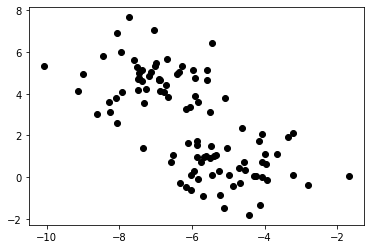

In [36]:
plt.scatter(pdf_kmedias['x'], pdf_kmedias['y'], c = 'black')

### 3.2.2 Preparar los datos

Para poder usar los modelos de `pyspark.ml` debemos reformatear los datos de la siguiente forma


In [37]:
# Da formato para poder usar datos en modelos de pyspark.ml

df_brutos = spark.createDataFrame(pdf_kmedias)

df_kmedias = df_brutos.withColumn('variables', array(df_brutos.columns)) \
                      .rdd.map(lambda renglon: Vectors.dense(renglon.variables))

df_kmedias = spark.createDataFrame(df_kmedias.map(Row), ['variables'])

df_kmedias.show(5, truncate = False)

+----------------------------------------+
|variables                               |
+----------------------------------------+
|[-10.064159673950533,5.3361298235882115]|
|[-5.93934529638521,0.2932430254612975]  |
|[-4.282810462818456,0.03337804988534199]|
|[-3.9682695610300134,0.6462729900646167]|
|[-5.580911813734784,5.119659218324231]  |
+----------------------------------------+
only showing top 5 rows



### 3.2.3 Entrenar modelo

A *ojo de buen cubero* se pueden distinguir dos grupos. Usemos K-medias para encontrar estos grupos. Entrenemos al modelo

In [44]:
# k es el numero de grupos (clusters)
kmedias = KMeans(k = 2, seed = 1, featuresCol = 'variables')
modelo = kmedias.fit(df_kmedias)

### 3.2.4 Hacer predicciones

Hagamos las predicciones

In [45]:
grupos_pred = modelo.transform(df_kmedias)

Pasemoslo a un DataFrame de pandas

In [46]:
grupos_pred = grupos_pred.toPandas()
grupos_pred = grupos_pred['prediction']
grupos_pred[:5]

0    0
1    1
2    1
3    1
4    0
Name: prediction, dtype: int32

Cambiamos a colores para graficar

In [47]:
grupos_colores = []

for g in grupos_pred:
  if g == 1:
    grupos_colores.append('blue')
  else:
    grupos_colores.append('red')

graficamos

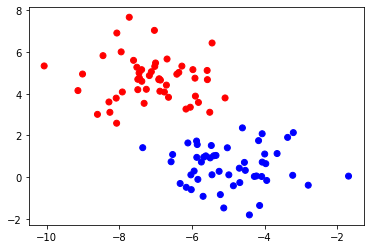

In [48]:
plt.scatter(pdf_kmedias['x'], pdf_kmedias['y'], c = grupos_colores)

### 3.2.5 Evaluar modelo


Podemos evaluar el modelo calculando la matriz de confusión

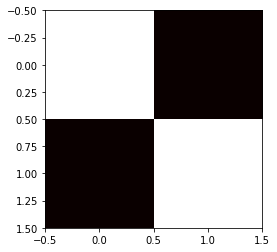

In [49]:
mat_cnf = confusion_matrix(grupos_real, grupos_pred)
plt.imshow(mat_cnf, cmap='hot', interpolation='nearest')
plt.show()

Notemos que probablemente el grupo real 1 hace referencia al grupo 0 predecido, debido a que no asignamos explícitamente etiquetas a los grupos, el comportamiento ideal sera cuando la mayor cantidad de clasificaciones aparezcan en cualquiera de las dos diagonales.


## 3.3 Otras formas de agrupar
A continuación presentamos más formas de realizar la tarea de agrupamiento en PySpark, las explicaciones de cada una de estas técnicas escapan a los propósitos de este notebook. Si el lector lo desea, deberá investigar por si mismo la teoría detrás de cada uno de estos


### 3.3.1 K-medias con distancia coseno

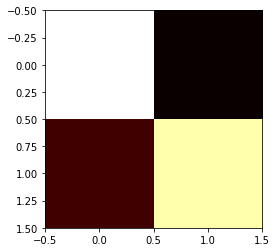

In [54]:
kmedias = KMeans(k = 2, seed = 1, featuresCol = 'variables', distanceMeasure = 'cosine')
modelo = kmedias.fit(df_kmedias)
grupos_pred = modelo.transform(df_kmedias)
grupos_pred = grupos_pred.toPandas()
grupos_pred = grupos_pred['prediction']
grupos_pred[:5]

mat_cnf = confusion_matrix(grupos_real, grupos_pred)
plt.imshow(mat_cnf, cmap='hot', interpolation='nearest')
plt.show()

### 3.3.2 *Gaussian mixture models*

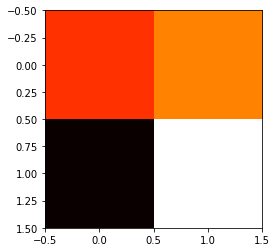

In [55]:
kmedias = GaussianMixture(k = 2, seed = 1, featuresCol = 'variables')
modelo = kmedias.fit(df_kmedias)
grupos_pred = modelo.transform(df_kmedias)
grupos_pred = grupos_pred.toPandas()
grupos_pred = grupos_pred['prediction']
grupos_pred[:5]

mat_cnf = confusion_matrix(grupos_real, grupos_pred)
plt.imshow(mat_cnf, cmap='hot', interpolation='nearest')
plt.show()

### 3.3.3 *Bisecting* K-medias

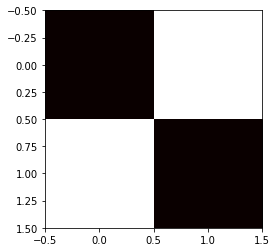

In [56]:
kmedias = BisectingKMeans(k = 2, seed = 1, featuresCol = 'variables')
modelo = kmedias.fit(df_kmedias)
grupos_pred = modelo.transform(df_kmedias)
grupos_pred = grupos_pred.toPandas()
grupos_pred = grupos_pred['prediction']
grupos_pred[:5]

mat_cnf = confusion_matrix(grupos_real, grupos_pred)
plt.imshow(mat_cnf, cmap='hot', interpolation='nearest')
plt.show()

## Ejercicio


1. Cree su propia base de datos cambiando el sus hiperparámetros de la función `make_blobs`. Grafique (si es posible) sus datos.
2. Emplee todos las técnicas de agrupamiento y reporte los resultados.

